# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

In [1]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Ансамбли

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [21]:
// df = pd.read_csv('e:/DS/ds_hw/mercari/train.tsv', nrows=100000, sep='\t')

In [2]:
df = pd.read_csv('e:/DS/ds_hw/mercari/train.tsv',  sep='\t')

In [3]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
main_category        1482535 non-null object
subcat_1             1482535 non-null object
subcat_2             1482535 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


In [6]:
!head mercari/sample_submission.csv

test_id,price
0,26.738
1,26.738
2,26.738
3,26.738
4,26.738
5,26.738
6,26.738
7,26.738
8,26.738


In [10]:
df_test = pd.read_csv('e:/DS/ds_hw/mercari/test.tsv', sep='\t')

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


In [12]:
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


Посмотрим на данные, общие статистики

In [4]:
df['price'].max(), df['price'].min(), df['price'].mean(),   df['price'].median()

(2009.0, 0.0, 26.737516146330442, 17.0)

Разделим категории

In [5]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [57]:
df['main_category'], df['subcat_1'], df['subcat_2'] = \
zip(*df['category_name'].apply(lambda x: split_cat(x)))
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [59]:
df['main_category'].nunique(), df['subcat_1'].nunique(), df['subcat_2'].nunique(), df['category_name'].nunique()

(11, 114, 871, 1287)

Посмотрим распределение товаров по категориям

In [60]:
x = df['main_category'].value_counts().index.values.astype('str')
y = df['main_category'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(df))]

In [38]:
y

array([664385, 207828, 171689, 122690,  93680,  67871,  46530,  45351,
        30842,  25342,   6327], dtype=int64)

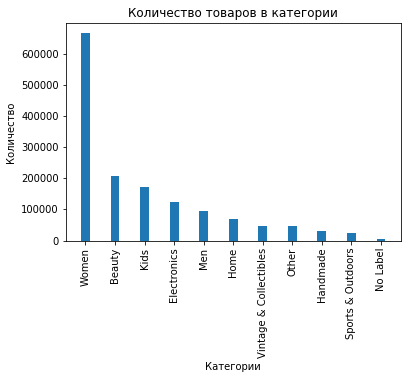

In [39]:

plt.bar(x,y,width=.3)
plt.xticks(x,x, rotation='vertical')
plt.xlabel('Категории')
plt.ylabel('Количество ')
plt.title('Количество товаров в категории')
plt.show()

In [70]:
df['item_condition_id'].astype('object')
t = df[df['subcat_2'] =='T-shirts'].groupby('brand_name')['price'].mean().to_frame().sort_values(['brand_name'], ascending = True)
/*средняя цена категории*/
pr = df[df['subcat_2'] =='T-shirts']['price'].mean()
pr

18.35249536669314

Посмотрим, насколько детализированы категории.

In [8]:
 df[df['subcat_1']=='Jeans'].groupby('subcat_2').count()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcat_1
subcat_2,,,,,,,,,,
"Baggy, Loose",54,54,54,54,36,54,54,54,54,54
Boot Cut,7234,7234,7234,7234,6671,7234,7234,7234,7234,7234
Boyfriend,805,805,805,805,683,805,805,805,805,805
"Capri, Cropped",1358,1358,1358,1358,1231,1358,1358,1358,1358,1358
Cargo,13,13,13,13,7,13,13,13,13,13
Carpenter,23,23,23,23,17,23,23,23,23,23
"Classic, Straight Leg",1754,1754,1754,1754,1580,1754,1754,1754,1754,1754
Flare,761,761,761,761,671,761,761,761,761,761
Leggings,6694,6694,6694,6694,3870,6694,6694,6694,6694,6694


In [9]:
df[df['subcat_2']=='Leggings']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,subcat_1,subcat_2
235,235,Under Armor Leggings,3,Women/Jeans/Leggings,Under Armour,14.00,0,Soft under armor leggings,Women,Jeans,Leggings
288,288,LuLaRoe OS hipster penguins,2,Women/Jeans/Leggings,LuLaRoe,27.00,1,"Brand new, never worn, no tag. Navy Blue backg...",Women,Jeans,Leggings
632,632,✨Soft Sateen Jeggings,2,Women/Jeans/Leggings,American Eagle,21.00,0,NWOT Blue AEO Sateen X Jeggings Really soft an...,Women,Jeans,Leggings
981,981,Lularoe Bambi Os,1,Women/Jeans/Leggings,Disney Collection,25.00,1,Brand new Disney leggings,Women,Jeans,Leggings
1614,1614,"""LIKE A BOSS"" Black Leggings",2,Women/Jeans/Leggings,NaN,19.00,0,Never worn! bought for 20 Size small,Women,Jeans,Leggings
1683,1683,Mommy and me set TC s/m,1,Women/Jeans/Leggings,NaN,45.00,1,Brand new,Women,Jeans,Leggings
1687,1687,American eagle jeggings size 10,3,Women/Jeans/Leggings,American Eagle,25.00,0,american Eagle / Jeggings / Size 10 / burnt or...,Women,Jeans,Leggings
1823,1823,Athletic leggings,2,Women/Jeans/Leggings,NaN,7.00,1,"Woman's size large athletic leggings, no signs...",Women,Jeans,Leggings
2078,2078,Lularoe grey solid TC,1,Women/Jeans/Leggings,NaN,16.00,1,Brand new light grey color. Great for fall!,Women,Jeans,Leggings
3285,3285,Lularoe Halloween Leggings OS,1,Women/Jeans/Leggings,NaN,38.00,1,"Brand new halloween leggings, with cats and gh...",Women,Jeans,Leggings


Категориии детализированы очень подробно, поэтому каждый товар в опрделенной категории, очень схожи, те если 
это джинсовые леггинсы, то каждый представитель этой категории очень похож на любой другой. Поэтому учитывая бранд 
и состояние можно уже сделать предсказание цены, с каким-то усреднением.



In [26]:
df.brand_name.fillna(value="Missing", inplace=True)


In [27]:
df[df['brand_name'].isnull()].count()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [28]:
df = df[df['category_name'].notnull()]

In [29]:
le = LabelEncoder()
le.fit(df.brand_name)
df['brand_name'] = le.transform(df.brand_name)

le.fit(df.category_name)
df['category_name'] = le.transform(df.category_name)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000000000575BA20>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [35]:
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,808,2876,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3545,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1254,4166,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,485,2876,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,1181,2876,44.00,0,Complete with certificate of authenticity


In [36]:
t = df.groupby(['item_condition_id','category_name','brand_name'], as_index = False)['price'].mean()


In [37]:
t.head(10)

,item_condition_id,category_name,brand_name,price
0,1,0,1,5.50
1,1,0,44,18.00
2,1,0,279,16.50
3,1,0,356,16.00
4,1,0,481,17.56
5,1,0,532,9.00
6,1,0,550,25.00
7,1,0,897,32.25
8,1,0,1046,33.00
9,1,0,1261,15.00


In [38]:
cols = ['item_condition_id','category_name','brand_name']


In [39]:
x_train = t[cols]
y_train = t['price']


In [50]:
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
y_pred = [round(value,2) for value in y_pred]
# evaluate predictions
mse = mean_squared_error(y_train, y_pred)
print("MSE: %.2f%%" % mse)


MSE: 976.35%


# Задание
1. Сделать baseline submission
  * Исследовать признак price. 
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
  * ...
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Скорректировать план
  * убрать пункты, которые кажутся неудачными
  * добавить идеи из kernel, кажущиеся удачными
7. Построить модель, выбрать лучшую
8. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
9. Применить и засабмитить лучшую на cv модель
10. Прислать блокнот и свой ник в лидерборде